In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

In [2]:
# 特徴量を追加すると、モデルは複雑になり、過剰適合の可能性が高くなる
# 新しい特徴量を加える場合、また高次元データセット一般の場合、最も有用な特徴量だけを残して残りを捨てて、特徴量の数を減らすのは良い考えだ
# 良い特徴量を見つける基本的な戦略が、単変量統計、モデルベース選択、反復選択の3つだ
# これらの方法はすべて教師あり手法なので、モデルを適合するためのターゲットが必要である
# 従って、データを訓練セットとテストセットに分割し、特徴量選択は、訓練セットだけを用いて行うようにしなければならない
# 機械学習アルゴリズムに対してどの特徴量を入力として使ったらよいかわからない場合には、自動特徴量選択は有用である
# 予測を高速化したい場合や、解釈しやすいモデルを構築したい場合などに、必要な特徴量の量を減らすためにも役に立つ
# 実世界のデータでは、特徴量選択で性能が大幅に向上することはあまりない

<h4>単変量統計</h4>

X_train.shape: (284, 80)
X_train_selected.shape: (284, 40)
[ True  True  True  True  True  True  True  True  True False  True False
  True  True  True  True  True  True False False  True  True  True  True
  True  True  True  True  True  True False False False  True False  True
 False False  True False False False False  True False False  True False
 False  True False  True False False False False False False  True False
  True False False False False  True False  True False False False False
  True  True False  True False False False False]


Text(0.5, 0, 'Sample index')

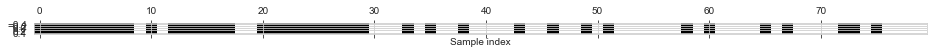

In [3]:
# 単変量統計では、個々の特徴量とターゲットとの間に統計的に顕著な関係があるかどうかを計算し、最も高い確信度で関連している特徴量が選択される
# クラス分類の場合は、分散分析（analysis of variance:anova）として知られる手法である
# この方法の特性は単変量であること、つまり個々の特徴量を個別に考慮することである
# 単変量特徴量選択をsklearnで使うには、テストを選択する必要がある。通常、クラス分類にはf_classif(default)を、回帰にはf_regressionを用いる
# さらに、テストで求められるp-値をもとに、特徴量を捨てる方法も指定する
# これらの方法には、p-値が大きすぎる（ターゲットと関係なさそうだということを意味する）特徴量を捨てる際のスレッショルドを指定する
# スレッショルドの計算方法は手法によって異なり、SelectKBestでは選択する特徴量の数を、SelectPercentileでは残す特徴量の割合を指定する
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split

# cancerデータに情報量のないのノイズを加え、これらノイズが取り除かれることを期待する
cancer = load_breast_cancer()
rng = np.random.RandomState(42)
noise = rng.normal(size = (len(cancer.data), 50))
X_w_noise = np.hstack([cancer.data, noise])

X_train, X_test, y_train, y_test = train_test_split(X_w_noise, cancer.target, random_state = 0, test_size = .5)
select = SelectPercentile(percentile = 50)
select.fit(X_train, y_train)
X_train_selected = select.transform(X_train)
print(f"X_train.shape: {X_train.shape}")
print(f"X_train_selected.shape: {X_train_selected.shape}")

# どの特徴量が使われているかをget_supportメソッドで調べることができる。このメソッドは選択された特徴量を示す真偽値のマスクを返す
mask = select.get_support()
print(mask)
plt.matshow(mask.reshape(1, -1), cmap = "gray_r")
plt.xlabel("Sample index")

In [4]:
# 特徴量が多すぎてモデルを作ることができないような場合や、多くの特徴量が全く関係ないと思われるような場合には、単変量特徴量選択は有用だ
from sklearn.linear_model import LogisticRegression

X_test_selected = select.transform(X_test)
lr = LogisticRegression(max_iter = 10000)
lr.fit(X_train, y_train)
print(f"Score with all features: {lr.score(X_test, y_test):.3f}")
lr.fit(X_train_selected, y_train)
print(f"Score with all features: {lr.score(X_test_selected, y_test):.3f}")

Score with all features: 0.951
Score with all features: 0.937


<h4>モデルベース特徴量選択</h4>

X_train.shape: (284, 80)
X_train_l1.shape: (284, 40)
Test score: 0.947


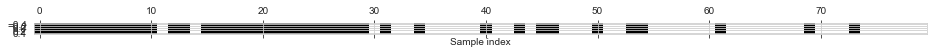

In [5]:
# モデルベース特徴量選択は、教師あり学習モデルを用いて個々の特徴量の重要性を判断し、重要なものだけを残す手法である
# 特徴量選択に用いる教師ありモデルは、最終的に使う教師あり学習モデルと同じでなくともよい
# 特徴量選択に用いるモデルは、選択時に特徴量に順番をつけるために、個々の特徴量の重要性の指標を出力するものでなければならない
# 決定木や決定木ベースのモデルには、特徴量の重要性そのものをエンコードしたfeature_importances_属性がある
# 線形モデルには係数があり、これも絶対値を取れば、特徴量の重要性を捉えた値として利用できる
# L1ペナルティを用いた線形モデルは、モデルによる特徴量選択として考えることもできるが、これを特徴量選択の前処理過程のみとして使うこともできる
# 単変量選択の場合と対照的に、モデルベースの選択は、すべての特徴量を同時に考慮するので、変数間の交互作用を捉えることができる
# モデルベース特徴量選択を用いるにはSelectFromModel変換器を用いればよい
# SelectFromModelクラスは教師あり学習モデルで得られた特徴量の重要性が、指定したスレッショルドよりも大きい特徴量だけを選択する
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

select = SelectFromModel(RandomForestClassifier(n_estimators = 100, random_state = 42), threshold = "median")
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)
print(f"X_train.shape: {X_train.shape}")
print(f"X_train_l1.shape: {X_train_l1.shape}")

mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap = "gray_r")
plt.xlabel("Sample index")

X_test_l1 = select.transform(X_test)
score = LogisticRegression(max_iter = 10000).fit(X_train_l1, y_train).score(X_test_l1, y_test)
print(f"Test score: {score:.3f}")

<h4>反復特徴量選択</h4>
<h4>--再帰的特徴量削減（recursive feature elimination : RFE）--</h4>

Test score: 0.940
Test score: 0.951


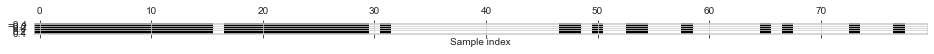

In [6]:
# 反復特徴量選択では、異なる特徴量を用いた一連のモデルを作り、これには異なる２つの方法がある
# 1. 全く特徴量を使わないところから、ある基準が満たされるところまで一つずつ特徴量を加えていく方法
# 2. すべての特徴量を使う状態から一つずつ特徴量を取り除いていく方法
# 再帰的特徴量削減：すべての特徴量から開始してモデルを作り、モデル作成⇒最も重要度が低い特徴量を削除、を事前に定めた数の特徴量になるまで繰り返す
# 再帰的特徴量削減が機能するためには、モデルベース選択の場合と同様に、選択に用いるモデルが特徴量の重要性を決定する方法を提供している必要がある
from sklearn.feature_selection import RFE

select = RFE(RandomForestClassifier(n_estimators = 100, random_state = 42), n_features_to_select = 40)
select.fit(X_train, y_train)
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap = "gray_r")
plt.xlabel("Sample index")

X_train_rfe = select.transform(X_train)
X_test_rfe = select.transform(X_test)
score = LogisticRegression(max_iter = 10000).fit(X_train_rfe, y_train).score(X_test_rfe, y_test)
print(f"Test score: {score:.3f}")
print(f"Test score: {select.score(X_test, y_test):.3f}")